# HM2: Numerical Optimization for Logistic Regression.

### Name: [Your-Name?]


## 0. You will do the following:

1. Read the lecture note: [click here](https://github.com/wangshusen/DeepLearning/blob/master/LectureNotes/Logistic/paper/logistic.pdf)

2. Read, complete, and run my code.

3. **Implement mini-batch SGD** and evaluate the performance.

4. Convert the .IPYNB file to .HTML file.

    * The HTML file must contain **the code** and **the output after execution**.
    
    * Missing **the output after execution** will not be graded.
    
5. Upload this .HTML file to your Google Drive, Dropbox, or your Github repo.  (If you submit the file to Google Drive or Dropbox, you must make the file "open-access". The delay caused by "deny of access" may result in late penalty.)

6. Submit the link to this .HTML file to Canvas.

    * Example: https://github.com/wangshusen/CS583-2020S/blob/master/homework/HM2/HM2.html


## Grading criteria:

1. When computing the ```gradient``` and ```objective function value``` using a batch of samples, use **matrix-vector multiplication** rather than a FOR LOOP of **vector-vector multiplications**.

2. Plot ```objective function value``` against ```epochs```. In the plot, compare GD, SGD, and MB-SGD (with $b=8$ and $b=64$). The plot must look reasonable.

# 1. Data processing

- Download the Diabete dataset from https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/diabetes
- Load the data using sklearn.
- Preprocess the data.

## 1.1. Load the data

In [449]:
from sklearn import datasets
import numpy as np

x_sparse, y = datasets.load_svmlight_file('data')
x = x_sparse.todense()

print('Shape of x: ' + str(x.shape))
print('Shape of y: ' + str(y.shape))

Shape of x: (768, 8)
Shape of y: (768,)


## 1.2. Partition to training and test sets

In [450]:
# partition the data to training and test sets
n = x.shape[0]
n_train = 640
n_test = n - n_train

rand_indices = np.random.permutation(n)
train_indices = rand_indices[0:n_train]
test_indices = rand_indices[n_train:n]

x_train = x[train_indices, :]
x_test = x[test_indices, :]
y_train = y[train_indices].reshape(n_train, 1)
y_test = y[test_indices].reshape(n_test, 1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))
print('Shape of y_train: ' + str(y_train.shape))
print('Shape of y_test: ' + str(y_test.shape))

Shape of x_train: (640, 8)
Shape of x_test: (128, 8)
Shape of y_train: (640, 1)
Shape of y_test: (128, 1)


## 1.3. Feature scaling

Use the standardization to trainsform both training and test features

In [451]:
# Standardization
import numpy

# calculate mu and sig using the training set
d = x_train.shape[1]
mu = np.mean(x_train, axis=0).reshape(1, d)
sig = np.std(x_train, axis=0).reshape(1, d)

# transform the training features
x_train = (x_train - mu) / (sig + 1E-6)

# transform the test features
x_test = (x_test - mu) / (sig + 1E-6)

print('test mean = ')
print(np.mean(x_test, axis=0))

print('test std = ')
print(np.std(x_test, axis=0))

test mean = 
[[-0.04550354 -0.0701998  -0.22835384  0.00670745 -0.0778767  -0.04154175
  -0.04362666 -0.10608447]]
test std = 
[[1.06341884 0.96638606 1.17307556 1.03773401 0.92932838 1.11043613
  1.08580615 0.90969329]]


## 1.4. Add a dimension of all ones

In [452]:
n_train, d = x_train.shape
x_train = np.concatenate((x_train, np.ones((n_train, 1))), axis=1)

n_test, d = x_test.shape
x_test = np.concatenate((x_test, np.ones((n_test, 1))), axis=1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))

Shape of x_train: (640, 9)
Shape of x_test: (128, 9)


# 2. Logistic regression model

The objective function is $Q (w; X, y) = \frac{1}{n} \sum_{i=1}^n \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $.

In [453]:
# Calculate the objective function value
# Inputs:
#     w: d-by-1 matrix
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
# Return:
#     objective function value (scalar)
def objective(w, x, y, lam):
    n, d = x.shape
    yx = np.multiply(y, x) # n-by-d matrix
    yxw = np.dot(yx, w) # n-by-1 matrix
    vec1 = np.exp(-yxw) # n-by-1 matrix
    vec2 = np.log(1 + vec1) # n-by-1 matrix
    loss = np.mean(vec2) # scalar
    reg = lam / 2 * np.sum(w * w) # scalar
    return loss + reg
    

In [454]:
# initialize w
d = x_train.shape[1]
w = np.zeros((d, 1))

# evaluate the objective function value at w
lam = 1E-6
objval0 = objective(w, x_train, y_train, lam)
print('Initial objective function value = ' + str(objval0))

Initial objective function value = 0.6931471805599453


# 3. Numerical optimization

## 3.1. Gradient descent


The gradient at $w$ is $g = - \frac{1}{n} \sum_{i=1}^n \frac{y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$

In [455]:
# Calculate the gradient
# Inputs:
#     w: d-by-1 matrix
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
# Return:
#     g: g: d-by-1 matrix, full gradient
def gradient(w, x, y, lam):
    n, d = x.shape
    yx = np.multiply(y, x) # n-by-d matrix
    yxw = np.dot(yx, w) # n-by-1 matrix
    vec1 = np.exp(yxw) # n-by-1 matrix
    vec2 = np.divide(yx, 1+vec1) # n-by-d matrix
    vec3 = -np.mean(vec2, axis=0).reshape(d, 1) # d-by-1 matrix
    g = vec3 + lam * w
    return g

In [456]:
# Gradient descent for solving logistic regression
# Inputs:
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     stepsize: scalar
#     max_iter: integer, the maximal iterations
#     w: d-by-1 matrix, initialization of w
# Return:
#     w: d-by-1 matrix, the solution
#     objvals: a record of each iteration's objective value
def grad_descent(x, y, lam, stepsize, max_iter=100, w=None):
    n, d = x.shape
    objvals = np.zeros(max_iter) # store the objective values
    if w is None:
        w = np.zeros((d, 1)) # zero initialization
    
    for t in range(max_iter):
        objval = objective(w, x, y, lam)
        objvals[t] = objval
        print('Objective value at t=' + str(t) + ' is ' + str(objval))
        g = gradient(w, x, y, lam)
        w -= stepsize * g
    
    return w, objvals

Run gradient descent.

In [457]:
lam = 1E-6
stepsize = 1.0
w, objvals_gd = grad_descent(x_train, y_train, lam, stepsize)

Objective value at t=0 is 0.6931471805599453
Objective value at t=1 is 0.5862892445125101
Objective value at t=2 is 0.5423084369714289
Objective value at t=3 is 0.5183517217293904
Objective value at t=4 is 0.5031932676414574
Objective value at t=5 is 0.4927892141181513
Objective value at t=6 is 0.48528812964174534
Objective value at t=7 is 0.47969940567579183
Objective value at t=8 is 0.47543545322381564
Objective value at t=9 is 0.47212244001507225
Objective value at t=10 is 0.4695104761502115
Objective value at t=11 is 0.4674263127072868
Objective value at t=12 is 0.46574639726024997
Objective value at t=13 is 0.464380590879606
Objective value at t=14 is 0.463261873991805
Objective value at t=15 is 0.46233960471929425
Objective value at t=16 is 0.46157497634321504
Objective value at t=17 is 0.46093788323159396
Objective value at t=18 is 0.4604047143092133
Objective value at t=19 is 0.45995677182470696
Objective value at t=20 is 0.459579120254756
Objective value at t=21 is 0.459259736

## 3.2. Stochastic gradient descent (SGD)

Define $Q_i (w) = \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $.

The stochastic gradient at $w$ is $g_i = \frac{\partial Q_i }{ \partial w} = -\frac{y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$.

In [458]:
# Calculate the objective Q_i and the gradient of Q_i
# Inputs:
#     w: d-by-1 matrix
#     xi: 1-by-d matrix
#     yi: scalar
#     lam: scalar, the regularization parameter
# Return:
#     obj: scalar, the objective Q_i
#     g: d-by-1 matrix, gradient of Q_i
def stochastic_objective_gradient(w, xi, yi, lam):
    d = xi.shape[0]
    yx = yi * xi # 1-by-d matrix
    yxw = float(numpy.dot(yx, w)) # scalar
    
    # calculate objective function Q_i
    loss = numpy.log(1 + numpy.exp(-yxw)) # scalar
    reg = lam / 2 * numpy.sum(w * w) # scalar
    obj = loss + reg
    
    # calculate stochastic gradient
    g_loss = -yx.T / (1 + numpy.exp(yxw)) # d-by-1 matrix
    g = g_loss + lam * w # d-by-1 matrix
    
    return obj, g

In [459]:
# SGD for solving logistic regression
# Inputs:
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     stepsize: scalar
#     max_epoch: integer, the maximal epochs
#     w: d-by-1 matrix, initialization of w
# Return:
#     w: the solution
#     objvals: record of each iteration's objective value
def sgd(x, y, lam, stepsize, max_epoch=100, w=None):
    n, d = x.shape
    objvals = np.zeros(max_epoch) # store the objective values
    if w is None:
        w = np.zeros((d, 1)) # zero initialization
    
    for t in range(max_epoch):
        # randomly shuffle the samples
        rand_indices = np.random.permutation(n)
        x_rand = x[rand_indices, :]
        y_rand = y[rand_indices, :]
        
        objval = 0 # accumulate the objective values
        for i in range(n):
            xi = x_rand[i, :] # 1-by-d matrix
            yi = float(y_rand[i, :]) # scalar
            obj, g = stochastic_objective_gradient(w, xi, yi, lam)
            objval += obj
            w -= stepsize * g
        
        stepsize *= 0.9 # decrease step size
        objval /= n
        objvals[t] = objval
        print('Objective value at epoch t=' + str(t) + ' is ' + str(objval))
    
    return w, objvals

Run SGD.

In [460]:
lam = 1E-6
stepsize = 0.1
w, objvals_sgd = sgd(x_train, y_train, lam, stepsize)

Objective value at epoch t=0 is 0.5193800168401703
Objective value at epoch t=1 is 0.5083773403967052
Objective value at epoch t=2 is 0.490817351089018
Objective value at epoch t=3 is 0.4936577544617564
Objective value at epoch t=4 is 0.48965293764384504
Objective value at epoch t=5 is 0.4891070071016041
Objective value at epoch t=6 is 0.4803970251741737
Objective value at epoch t=7 is 0.48119027492154204
Objective value at epoch t=8 is 0.47522209988373587
Objective value at epoch t=9 is 0.4759667358597651
Objective value at epoch t=10 is 0.4761528665522522
Objective value at epoch t=11 is 0.46904045761500013
Objective value at epoch t=12 is 0.46923107819539717
Objective value at epoch t=13 is 0.4727975489626576
Objective value at epoch t=14 is 0.46837460754417687
Objective value at epoch t=15 is 0.4700497661552956
Objective value at epoch t=16 is 0.46846290312425964
Objective value at epoch t=17 is 0.4661315359792456
Objective value at epoch t=18 is 0.4648889897815184
Objective value 

# 4. Compare GD with SGD

Plot objective function values against epochs.

/Users/jig728/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  if __name__ == '__main__':
/Users/jig728/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  # Remove the CWD from sys.path while we load stuff.
/Users/jig728/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  # This is added back by InteractiveShellApp.init_path()
/Users/jig728/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases la

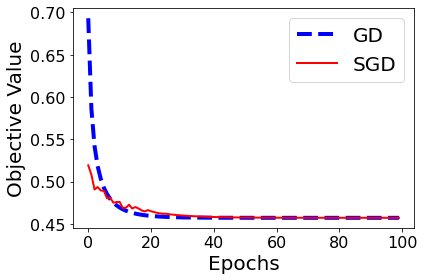

In [461]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(6, 4))

epochs_gd = range(len(objvals_gd))
epochs_sgd = range(len(objvals_sgd))

line0, = plt.plot(epochs_gd, objvals_gd, '--b', LineWidth=4)
line1, = plt.plot(epochs_sgd, objvals_sgd, '-r', LineWidth=2)
plt.xlabel('Epochs', FontSize=20)
plt.ylabel('Objective Value', FontSize=20)
plt.xticks(FontSize=16)
plt.yticks(FontSize=16)
plt.legend([line0, line1], ['GD', 'SGD'], fontsize=20)
plt.tight_layout()
plt.show()
fig.savefig('compare_gd_sgd.pdf', format='pdf', dpi=1200)

# 5. Prediction

In [462]:
# Predict class label
# Inputs:
#     w: d-by-1 matrix
#     X: m-by-d matrix
# Return:
#     f: m-by-1 matrix, the predictions
def predict(w, X):
    xw = np.dot(X, w)
    f = np.sign(xw)
    return f

In [463]:
# evaluate training error
f_train = predict(w, x_train)
diff = np.abs(f_train - y_train) / 2
error_train = np.mean(diff)
print('Training classification error is ' + str(error_train))

Training classification error is 0.20625


In [464]:
# evaluate test error
f_test = predict(w, x_test)
diff = np.abs(f_test - y_test) / 2
error_test = np.mean(diff)
print('Test classification error is ' + str(error_test))

Test classification error is 0.25


# 6. Mini-batch SGD (fill the code)



## 6.1. Compute the objective $Q_I$ and its gradient using a batch of samples

Define $Q_I (w) = \frac{1}{b} \sum_{i \in I} \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $, where $I$ is a set containing $b$ indices randomly drawn from $\{ 1, \cdots , n \}$ without replacement.

The stochastic gradient at $w$ is $g_I = \frac{\partial Q_I }{ \partial w} = \frac{1}{b} \sum_{i \in I} \frac{- y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$.

In [465]:
# Calculate the objective Q_I and the gradient of Q_I
# Inputs:
#     w: d-by-1 matrix
#     xi: b-by-d matrix
#     yi: b-by-1 matrix
#     lam: scalar, the regularization parameter
#     b: integer, the batch size
# Return:
#     obj: scalar, the objective Q_i
#     g: d-by-1 matrix, gradient of Q_i
def mb_stochastic_objective_gradient(w, xi, yi, lam, b):
    # Fill the function
    # Follow the implementation of stochastic_objective_gradient
    # Use matrix-vector multiplication; do not use FOR LOOP of vector-vector multiplications
    d = xi.shape[0]

    yx = np.multiply(yi, xi)

    yxw = np.dot(yx, w)
    
    # calculate objective function Q_i
    loss = np.log(1 + np.exp(-yxw)) # scalar
    reg = lam / 2 * np.sum(w * w) # scalar
    obj = (np.sum(loss) + reg) / b

    # calculate stochastic gradient
    g_loss = np.dot(-yx.T, 1/(1 + np.exp(yxw)))
    g = g_loss + lam * w 
    
    
    return obj, g

## 6.2. Implement mini-batch SGD

Hints:
1. In every epoch, randomly permute the $n$ samples (just like SGD).
2. Each epoch has $\frac{n}{b}$ iterations. In every iteration, use $b$ samples, and compute the gradient and objective using the ``mb_stochastic_objective_gradient`` function. In the next iteration, use the next $b$ samples, and so on.


In [466]:
# Reusable function
def create_batch(x, y, size):
    batches = []
    indices = np.arange(x.shape[0])
    np.random.shuffle(indices)

    for i in range(0, x.shape[0] - size + 1, size):
        mini = indices[i:i + size]
        yield x[mini], y[mini]
        
# Mini-Batch SGD for solving logistic regression
# Inputs:
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     b: integer, the batch size
#     stepsize: scalar
#     max_epoch: integer, the maximal epochs
#     w: d-by-1 matrix, initialization of w
# Return:
#     w: the solution
#     objvals: record of each iteration's objective value

def mb_sgd(x, y, lam, b, stepsize, max_epoch=100, w=None):
    # Fill the function
    # Follow the implementation of sgd
    # Record one objective value per epoch (not per iteration!)
    
    n, d = x.shape
    objvals = numpy.zeros(max_epoch) # store the objective values
    it = int(n/b)
    if w is None:
        w = numpy.zeros((d, 1)) # zero initialization
    
    for t in range(max_epoch):
        # randomly shuffle the samples
        rand_indices = numpy.random.permutation(n)
        x_rand = x[rand_indices, :]
        y_rand = y[rand_indices, :]
        
        objval = 0 # accumulate the objective values
        for mini in create_batch(x, y, b):
            mini_x, mini_y = mini
            obj, gradient = mb_stochastic_objective_gradient(w, mini_x, mini_y, lam, b)
            objval += obj
            w -= stepsize * gradient
        
        stepsize *= 0.9 # decrease step size
        objval /= it
        objvals[t] = objval
        print('Objective value at epoch t=' + str(t) + ' is ' + str(objval))
        
    
    return w, objvals

## 6.3. Run MB-SGD

In [467]:
# MB-SGD with batch size b=8
lam = 1E-6 # do not change
b = 8 # do not change
stepsize = 0.1 # you must tune this parameter
w, objvals_mbsgd8 = mb_sgd(x_train, y_train, lam, b, stepsize)

f_train = predict(w, x_train)
diff = np.abs(f_train - y_train) / 2
error_train = np.mean(diff)
print('Training classification error is ' + str(error_train))

f_test = predict(w, x_test)
diff = np.abs(f_test - y_test) / 2
error_test = np.mean(diff)
print('Test classification error is ' + str(error_test))


Objective value at epoch t=0 is 0.5143399110979131
Objective value at epoch t=1 is 0.5041780330130584
Objective value at epoch t=2 is 0.4944475600236219
Objective value at epoch t=3 is 0.4975322730391659
Objective value at epoch t=4 is 0.497410233998671
Objective value at epoch t=5 is 0.4831115183357423
Objective value at epoch t=6 is 0.48831077626642455
Objective value at epoch t=7 is 0.4793902496487676
Objective value at epoch t=8 is 0.4761370068009995
Objective value at epoch t=9 is 0.47979637275115905
Objective value at epoch t=10 is 0.47469502836087696
Objective value at epoch t=11 is 0.4763024019361006
Objective value at epoch t=12 is 0.47294499893099734
Objective value at epoch t=13 is 0.4735753642795214
Objective value at epoch t=14 is 0.47256275705642004
Objective value at epoch t=15 is 0.4689871129718982
Objective value at epoch t=16 is 0.4677393899278429
Objective value at epoch t=17 is 0.4659353968421097
Objective value at epoch t=18 is 0.46612653246595503
Objective value a

In [468]:
stepsize_2 = 0.15 # you must tune this parameter

w, objvals_mbsgd8_2 = mb_sgd(x_train, y_train, lam, b, stepsize_2)

f_train = predict(w, x_train)
diff = np.abs(f_train - y_train) / 2
error_train = np.mean(diff)
print('Training classification error is ' + str(error_train))

f_test = predict(w, x_test)
diff = np.abs(f_test - y_test) / 2
error_test = np.mean(diff)
print('Test classification error is ' + str(error_test))

Objective value at epoch t=0 is 0.5240100251976821
Objective value at epoch t=1 is 0.5048503118455752
Objective value at epoch t=2 is 0.5318256734625135
Objective value at epoch t=3 is 0.5134440413144241
Objective value at epoch t=4 is 0.5076154111189852
Objective value at epoch t=5 is 0.5034158934608312
Objective value at epoch t=6 is 0.49859562528303353
Objective value at epoch t=7 is 0.48915772790703504
Objective value at epoch t=8 is 0.4906771382056303
Objective value at epoch t=9 is 0.48806707608706335
Objective value at epoch t=10 is 0.480014586169861
Objective value at epoch t=11 is 0.47633553449748345
Objective value at epoch t=12 is 0.4768754136487134
Objective value at epoch t=13 is 0.47608864492028147
Objective value at epoch t=14 is 0.4727606908771362
Objective value at epoch t=15 is 0.47386477263266824
Objective value at epoch t=16 is 0.4734025809178088
Objective value at epoch t=17 is 0.47291614007206817
Objective value at epoch t=18 is 0.4699724685212322
Objective value 

In [469]:
# MB-SGD with batch size b=64
lam = 1E-6 # do not change
b = 64 # do not change
stepsize = 0.1 # you must tune this parameter

w, objvals_mbsgd64 = mb_sgd(x_train, y_train, lam, b, stepsize)

f_train = predict(w, x_train)
diff = np.abs(f_train - y_train) / 2
error_train = np.mean(diff)
print('Training classification error is ' + str(error_train))

f_test = predict(w, x_test)
diff = np.abs(f_test - y_test) / 2
error_test = np.mean(diff)
print('Test classification error is ' + str(error_test))

Objective value at epoch t=0 is 0.633155867463653
Objective value at epoch t=1 is 0.5111247801365587
Objective value at epoch t=2 is 0.49614331404367257
Objective value at epoch t=3 is 0.5339713963582146
Objective value at epoch t=4 is 0.5146280752178444
Objective value at epoch t=5 is 0.5067705289678381
Objective value at epoch t=6 is 0.5007951955554176
Objective value at epoch t=7 is 0.4969606484443627
Objective value at epoch t=8 is 0.4783726812563941
Objective value at epoch t=9 is 0.4790293146602688
Objective value at epoch t=10 is 0.4814881817460746
Objective value at epoch t=11 is 0.48476044468369395
Objective value at epoch t=12 is 0.47942809745552245
Objective value at epoch t=13 is 0.4711214469622013
Objective value at epoch t=14 is 0.4663391489567198
Objective value at epoch t=15 is 0.46768653455508735
Objective value at epoch t=16 is 0.46982040100098654
Objective value at epoch t=17 is 0.4681353988104696
Objective value at epoch t=18 is 0.46626225091713724
Objective value a

In [470]:
stepsize_2 = 0.15 # you must tune this parameter

w, objvals_mbsgd64_2 = mb_sgd(x_train, y_train, lam, b, stepsize_2)

f_train = predict(w, x_train)
diff = np.abs(f_train - y_train) / 2
error_train = np.mean(diff)
print('Training classification error is ' + str(error_train))

f_test = predict(w, x_test)
diff = np.abs(f_test - y_test) / 2
error_test = np.mean(diff)
print('Test classification error is ' + str(error_test))

Objective value at epoch t=0 is 0.5904666763555756
Objective value at epoch t=1 is 0.7645720163226802
Objective value at epoch t=2 is 0.586181764753134
Objective value at epoch t=3 is 0.6009455837930948
Objective value at epoch t=4 is 0.559781552307627
Objective value at epoch t=5 is 0.5658507138617844
Objective value at epoch t=6 is 0.5103440228219879
Objective value at epoch t=7 is 0.5280332296747507
Objective value at epoch t=8 is 0.4942685159416368
Objective value at epoch t=9 is 0.4996347485525465
Objective value at epoch t=10 is 0.4806404848854401
Objective value at epoch t=11 is 0.47540631096453667
Objective value at epoch t=12 is 0.4786110257107362
Objective value at epoch t=13 is 0.47370416290445067
Objective value at epoch t=14 is 0.47904920554835984
Objective value at epoch t=15 is 0.4726978028651233
Objective value at epoch t=16 is 0.47882789355014965
Objective value at epoch t=17 is 0.4713567992675188
Objective value at epoch t=18 is 0.47520678675798855
Objective value at 

# 7. Plot and compare GD, SGD, and MB-SGD

You are required to compare the following algorithms:

- Gradient descent (GD)

- SGD

- MB-SGD with b=8

- MB-SGD with b=64

Follow the code in Section 4 to plot ```objective function value``` against ```epochs```. There should be four curves in the plot; each curve corresponds to one algorithm.

Hint: Logistic regression with $\ell_2$-norm regularization is a strongly convex optimization problem. All the algorithms will converge to the same solution. **In the end, the ``objective function value`` of the 4 algorithms will be the same. If not the same, your implementation must be wrong. Do NOT submit wrong code and wrong result!**

/Users/jig728/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  app.launch_new_instance()
/Users/jig728/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
/Users/jig728/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
/Users/jig728/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
/Users/jig728/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarni

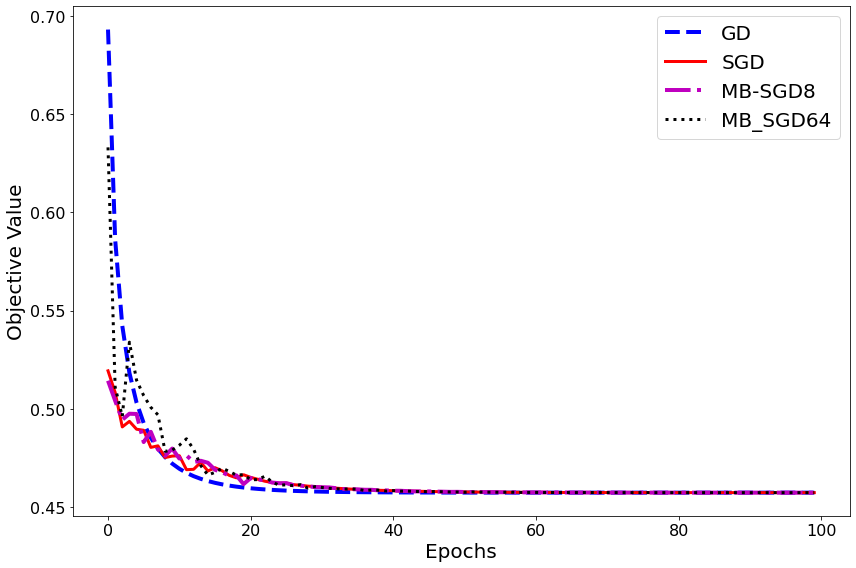

In [471]:
# plot the 4 curves:
# plt.subplot(2,2,1)
# plt.plot(lost_sg)
# plt.subplot(2,2,2)
# plt.plot(values_sg)


fig = plt.figure(figsize=(12, 8))

epochs_gd = range(len(objvals_gd))
epochs_sgd = range(len(objvals_sgd))
epochs_mbsgd8 = range(len(objvals_mbsgd8))
epochs_mbsgd64 = range(len(objvals_mbsgd64))


line0, = plt.plot(epochs_gd, objvals_gd, '--b', LineWidth=4)
line1, = plt.plot(epochs_sgd, objvals_sgd, '-r', LineWidth=3)
line2, = plt.plot(epochs_mbsgd8, objvals_mbsgd8, '-.m', LineWidth=4)
line3, = plt.plot(epochs_mbsgd64, objvals_mbsgd64, ':k', LineWidth=3)
plt.xlabel('Epochs', FontSize=20)
plt.ylabel('Objective Value', FontSize=20)
plt.xticks(FontSize=16)
plt.yticks(FontSize=16)
plt.legend([line0, line1, line2, line3], ['GD', 'SGD', 'MB-SGD8', 'MB_SGD64'], fontsize=20)
plt.tight_layout()
plt.show()
fig.savefig('compare_gd_sgd_mbsgd8_mbsgd64.pdf', format='pdf', dpi=1200)

/Users/jig728/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  if __name__ == '__main__':
/Users/jig728/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  # Remove the CWD from sys.path while we load stuff.
/Users/jig728/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  # This is added back by InteractiveShellApp.init_path()
/Users/jig728/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases la

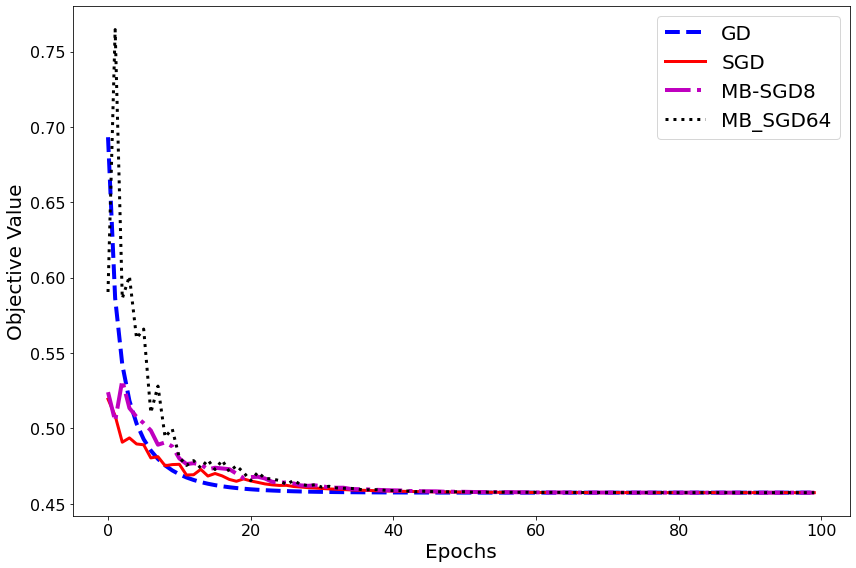

In [472]:

fig = plt.figure(figsize=(12, 8))

epochs_gd = range(len(objvals_gd))
epochs_sgd = range(len(objvals_sgd))
epochs_mbsgd8_2 = range(len(objvals_mbsgd8_2))
epochs_mbsgd64_2 = range(len(objvals_mbsgd64_2))


line0, = plt.plot(epochs_gd, objvals_gd, '--b', LineWidth=4)
line1, = plt.plot(epochs_sgd, objvals_sgd, '-r', LineWidth=3)
line2, = plt.plot(epochs_mbsgd8, objvals_mbsgd8_2, '-.m', LineWidth=4)
line3, = plt.plot(epochs_mbsgd64, objvals_mbsgd64_2, ':k', LineWidth=3)
plt.xlabel('Epochs', FontSize=20)
plt.ylabel('Objective Value', FontSize=20)
plt.xticks(FontSize=16)
plt.yticks(FontSize=16)
plt.legend([line0, line1, line2, line3], ['GD', 'SGD', 'MB-SGD8', 'MB_SGD64'], fontsize=20)
plt.tight_layout()
plt.show()
fig.savefig('compare_gd_sgd_mbsgd8_mbsgd64_2.pdf', format='pdf', dpi=1200)